In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams
import matplotlib.patches as mpatches

from sklearn.preprocessing import minmax_scale,scale


import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as he
import importlib
importlib.reload(he)
import helper as he

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

from rpy2.robjects.packages import importr
grdevices = importr('grDevices')

In [2]:
%%R
library('ComplexHeatmap')
library(viridis)

In [2]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_de='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/de/'
path_de1=path_de+'de_diseased_T1_NODelim_meld/'
path_de2=path_de+'de_diseased_T2_VSGSTZ_meld_covarStudy/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'

In [3]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [4]:
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')
adata_rn_b.shape

(102143, 30672)

DE cluster scores

In [5]:
# Load T1 and T2 DE results
summary_t1=pd.read_table(path_de1+'deDataClusters.tsv',index_col=0)
summary_t2=pd.read_table(path_de2+'deDataClusters.tsv',index_col=0)

In [6]:
# gene cluster scores
adata_rn_b.obs.drop([col for col in adata_rn_b.obs.columns 
                     if 'gene_score_cluster_' in col],axis=1,inplace=True)
for td,summary in [('NOD',summary_t1),('db/db+mSTZ',summary_t2)]:
    for cl in sorted(summary['hc'].dropna().unique()):
        score_name='gene_score_cluster_'+td+'_'+str(cl)
        print(score_name)
        sc.tl.score_genes(adata_rn_b, 
                          gene_list=summary.query('hc==@cl').index, 
                         score_name=score_name, use_raw=False)
        adata_rn_b.obs[score_name+'_scaled']=minmax_scale(adata_rn_b.obs[score_name])

gene_score_cluster_NOD_down_1
gene_score_cluster_NOD_down_2
gene_score_cluster_NOD_down_3
gene_score_cluster_NOD_down_4
gene_score_cluster_NOD_down_5
gene_score_cluster_NOD_up_1
gene_score_cluster_NOD_up_2
gene_score_cluster_NOD_up_3
gene_score_cluster_NOD_up_4
gene_score_cluster_db/db+mSTZ_down_1
gene_score_cluster_db/db+mSTZ_down_2
gene_score_cluster_db/db+mSTZ_down_3
gene_score_cluster_db/db+mSTZ_down_4
gene_score_cluster_db/db+mSTZ_down_5
gene_score_cluster_db/db+mSTZ_down_6
gene_score_cluster_db/db+mSTZ_down_7
gene_score_cluster_db/db+mSTZ_up_1
gene_score_cluster_db/db+mSTZ_up_2
gene_score_cluster_db/db+mSTZ_up_3


Heatmap on fine beta cell states

In [8]:
# Prepare heatmap data
x=adata_rn_b.obs[[col for col in adata_rn_b.obs.columns 
                if 'gene_score_cluster_' in col and '_scaled' not in col]]

# Mean within beta clusters of gene programs
x['cl']=adata_rn_b.obs.loc[x.index, 'hc_gene_programs_parsed']
# Remove low Q
x=x.query('~cl.str.contains("lowQ")',engine='python')
x=x.groupby('cl', observed=True).mean()
x=x[['low_quality' not in i for i in x.index]]
x.index.name='fine cell clusters'
x=pd.DataFrame(minmax_scale(x),   index=x.index,   columns=x.columns)
x.columns=[c.replace('gene_score_cluster_','') for c in  x.columns]

# Order 
# Order columns by type of DE first before by expression pattern - UNUSED
col_order=[]
de_groups_order=['NOD_down','NOD_up','db/db+mSTZ_down','db/db+mSTZ_up']
for de in de_groups_order:
    cols=np.array([c for c in x.columns if c.startswith(de)])
    #if len(cols)>2:
    #    cols=cols[he.opt_order( x[cols].T, metric='correlation',  method='ward')]
    col_order.extend(cols)
x=x.loc[:,col_order]
#x=x.loc[x.index[he.opt_order(x,metric='correlation',  method='ward')],:]

<ipython-input-8-eb89c688416c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['cl']=adata_rn_b.obs.loc[x.index, 'hc_gene_programs_parsed']


In [9]:
# heatmap Col colors for type of gene group
cmap={'NOD_up':'#656F02','NOD_down':'#B5CE76',
      'db/db+mSTZ_up':'#9A008C','db/db+mSTZ_down':'#F79DD4'}
column_groups=['_'.join(c.split('_')[:-1]) for c in x.columns]
col_colors=pd.Series([cmap[c] for c in column_groups],
                     index=x.columns)

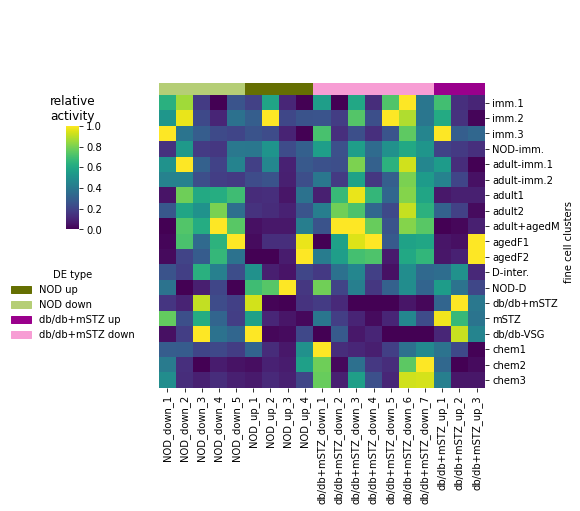

In [10]:
# Heatmap
w_dend=1.5
nrow=x.shape[0]*0.3
ncol=x.shape[1]*0.3
w=ncol+w_dend
h=nrow+w_dend
g=sb.clustermap(x,figsize=(w,h),col_colors=col_colors,
                col_cluster=False,row_cluster=False,
               xticklabels=True,yticklabels=True,cmap='viridis',
               cbar_pos=(0,0.55,0.025,0.2))
g.ax_cbar.set_title('relative\nactivity')
g.ax_col_colors.tick_params(axis='both', which='both', length=0)

# Legend for DE type
l=plt.legend(handles=[mpatches.Patch(color=c, label=l.replace('_',' ')) for l,c in cmap.items()],
          bbox_to_anchor=(6,-0.3),title='DE type')
l.get_frame().set_alpha(0)

# Save
plt.savefig(path_fig+'heatmap_beta_DENODelim-VSGSTZactivity_finecl.png',dpi=300,bbox_inches='tight')

C: Dont do standard scale on cells as this is affected by population sizes.

As above but with column gaps

In [100]:
# Add to R expression and de direction
x_plot=x.copy()
x_plot.columns=[i.replace('NOD_','T1-').replace('db/db+mSTZ_','T2-').replace('_','') 
                for i in x_plot.columns]
ro.globalenv['x']=x_plot
ro.globalenv['de_group']=column_groups
ro.globalenv['de_groups_order']=de_groups_order
ro.globalenv['de_groups_order_parsed']=[g.replace('_','\n') for g in de_groups_order]
ro.globalenv['de_groups_colors']=[cmap[c] for c in de_groups_order]

In [101]:
%%R
# DE direction anno
ha_col = columnAnnotation(
    direction = anno_block(gp = gpar(fill = unlist(de_groups_colors), col='white'), 
                           labels = unlist(de_groups_order_parsed),
                           height = unit(1, "cm"),
                           labels_gp = gpar(col = c('black','white','black','white'))),
    annotation_name_side = "left"
)
# Order DE groups
de_group<-factor(as.vector(unlist(de_group)),levels = unlist(de_groups_order))

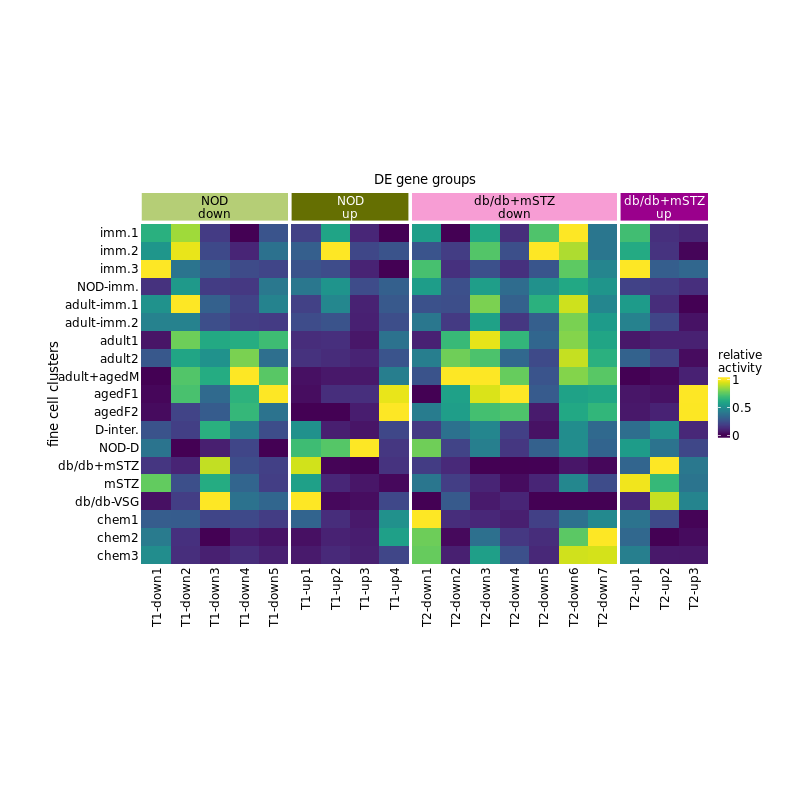

In [116]:
%%R -w 800 -h 800 
# plot heatmap
h<-Heatmap(x,col=viridis(256),
       cluster_columns = FALSE, cluster_rows = FALSE,
       show_column_names = TRUE, show_row_names = TRUE,
       row_title ="fine cell clusters",
       top_annotation=ha_col,
       column_split =de_group,
       column_title = 'DE gene groups',
       row_names_side = "left",
       heatmap_legend_param = list( title = "relative\nactivity", 
                                   title_gp=gpar( fontsize = 12),
                                   labels_gp = gpar( fontsize = 12)),
       row_gap = unit(1, "mm"),
       width= unit(20, "cm"), height= unit(12, "cm"),
       show_row_dend = FALSE, 
       )
draw(h)

In [119]:
%%R -i path_fig
# Save heatmap
pdf(file=paste0(path_fig,"heatmap_beta_DENODelim-VSGSTZactivity_finecl_gaps.pdf"), 
    width=10, height=6.4) 
h<-Heatmap(x,col=viridis(256),
       cluster_columns = FALSE, cluster_rows = FALSE,
       show_column_names = TRUE, show_row_names = TRUE,
       row_title ="fine cell clusters",
       top_annotation=ha_col,
       column_split =de_group,
       column_title = 'DE gene groups',
       row_names_side = "left",
       heatmap_legend_param = list( title = "relative\nactivity", 
                                   title_gp=gpar( fontsize = 12),
                                   labels_gp = gpar( fontsize = 12)),
       row_gap = unit(1, "mm"),
       width= unit(20, "cm"), height= unit(12, "cm"),
       show_row_dend = FALSE, 
       )
draw(h)

Coarse beta cell states heatmap

In [11]:
# Prepare heatmap data
x=adata_rn_b.obs[[col for col in adata_rn_b.obs.columns 
                if 'gene_score_cluster_' in col and '_scaled' not in col]]


# Mean within beta clusters of gene programs
x['cl']=adata_rn_b.obs.loc[x.index, 'leiden_r1.5_parsed']
x=x.query('~cl.str.contains("lowQ")',engine='python')
x=x.groupby('cl', observed=True).mean()
x.index.name='coarse cell clusters'
x=x[['low_quality' not in i for i in x.index]]
x=pd.DataFrame(minmax_scale(x),   index=x.index,   columns=x.columns)
x.columns=[c.replace('gene_score_cluster_','') for c in  x.columns]

# Order 
# Order columns by type of DE first before by expression pattern - UNUSED
col_order=[]
for de in ['NOD_down','NOD_up','db/db+mSTZ_down','db/db+mSTZ_up']:
    cols=np.array([c for c in x.columns if c.startswith(de)])
    #if len(cols)>2:
    #    cols=cols[he.opt_order( x[cols].T, metric='correlation',  method='ward')]
    col_order.extend(cols)
x=x.loc[:,col_order]
#x=x.loc[x.index[he.opt_order(x,metric='correlation',  method='ward')],:]

<ipython-input-11-cacf1b19e6e3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['cl']=adata_rn_b.obs.loc[x.index, 'leiden_r1.5_parsed']


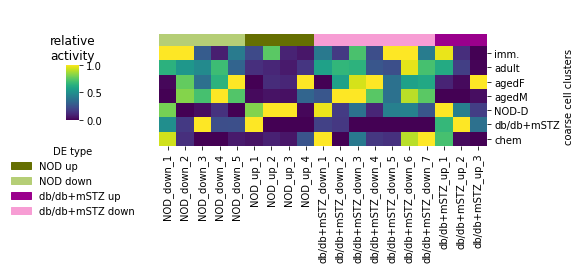

In [13]:
# Heatmap
w_dend=1.5
w_colors=0.35
nrow=x.shape[0]*0.33
ncol=x.shape[1]*0.3
w=ncol+w_dend
h=nrow+w_dend+w_colors
g=sb.clustermap(x,figsize=(w,h),col_colors=col_colors,
                col_cluster=False,row_cluster=False,
                colors_ratio=(w_colors/w,w_colors/h),
               xticklabels=True,yticklabels=True,cmap='viridis',
               cbar_pos=(0,0.55,0.025,0.2))
g.ax_cbar.set_title('relative\nactivity')
g.ax_col_colors.tick_params(axis='both', which='both', length=0)

# Legend for DE type
l=plt.legend(handles=[mpatches.Patch(color=c, label=l.replace('_',' ')) for l,c in cmap.items()],
          bbox_to_anchor=(6,-0.3),title='DE type')
l.get_frame().set_alpha(0)

# Save
plt.savefig(path_fig+'heatmap_beta_DENODelim-VSGSTZactivity_coarsecl.png',dpi=300,bbox_inches='tight')